# Importing Packages

In [4]:
import keras
keras.__version__

'2.15.0'

In [5]:
# Built-in Imports
import random

In [6]:
# Library Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [7]:
# Keras Imports
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import get_file, to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Dataset Downloader
This section will download the selected [MedMNIST](https://medmnist.github.io/) dataset as a NumPy array object to your Google Colab instance.

This code was directly adapted from Jacob Carse's notebook, as provided in the assignment notebook.

In [8]:
DATA_NAME = "OrganCMNIST"

In [9]:
!wget https://raw.githubusercontent.com/MedMNIST/MedMNIST/main/medmnist/info.py
from info import INFO
data = INFO[DATA_NAME.lower()]

--2024-03-29 01:50:18--  https://raw.githubusercontent.com/MedMNIST/MedMNIST/main/medmnist/info.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27766 (27K) [text/plain]
Saving to: ‘info.py’

info.py             100%[===================>]  27.12K  --.-KB/s    in 0.002s  

2024-03-29 01:50:18 (17.1 MB/s) - ‘info.py’ saved [27766/27766]



In [10]:
# Downloads the dataset file hosted on Zenodo.
file_path = get_file(fname="dataset.npz",
                     origin=data["url"],
                     md5_hash=data["MD5"])

15526411/15526411 [==============================] - 2s 0us/step


In [11]:
# Loads the downloaded NumPy object.
dataset = np.load(file_path)

# Gets the training images and labels from the NumPy object.
train_x = dataset["train_images"]
train_y = dataset["train_labels"]

# Gets the validation images and labels from the NumPy object.
val_x = dataset["val_images"]
val_y = dataset["val_labels"]

# Gets the testing images and labels from the NumPy object.
test_x = dataset["test_images"]
test_y = dataset["test_labels"]

#Check the array of the input data
print("Shape of train_x array:", train_x.shape)
print("Shape of train_y array:", train_y.shape)

Shape of train_x array: (12975, 28, 28)
Shape of train_y array: (12975, 1)


## Data Exploration
In this section we have a look at our data, their distributions to see if it is ready to be used within our machine learning algorithm.

In [13]:
# Declares a list of labels.
labels = list(data["label"].values()) + ["total"]

# Gets the counts for each label in each of our datasets.
_, train_counts = np.unique(train_y, return_counts=True)
_, val_counts = np.unique(val_y, return_counts=True)
_, test_counts = np.unique(test_y, return_counts=True)

# Prints the counts for each label from each dataset.
print(pd.DataFrame(list(zip(np.append(train_counts, [sum(train_counts)]),
                            np.append(val_counts, [sum(val_counts)]),
                            np.append(test_counts, [sum(test_counts)]))),
                   index=labels, columns=["Train", "Val", "Test"]))

              Train   Val  Test
bladder        1148   191   828
femur-left      619   102   431
femur-right     595    96   421
heart           600   202   421
kidney-left    1088   132   727
kidney-right   1170   157   735
liver          2986   429  1835
lung-left      1002   347   549
lung-right     1022   352   557
pancreas       1173   179   750
spleen         1572   205   962
total         12975  2392  8216


962: liver
Minimum pixel value: 0, Maximum pixel value: 255


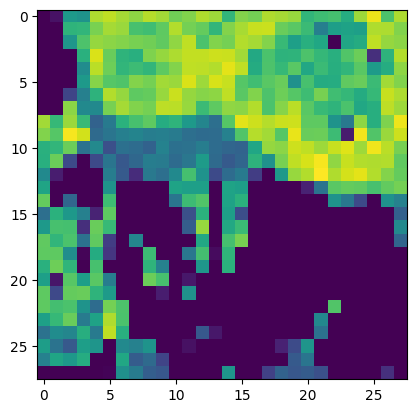

In [14]:
# Displays a random image from training dataset.
index = random.randint(0, len(train_x))
print(f"{index}: {labels[train_y[index][0]]}")
plt.imshow(train_x[random.randint(0, len(train_x))])

image = train_x[index]
min_pixel_value = np.min(image)
max_pixel_value = np.max(image)
print(f"Minimum pixel value: {min_pixel_value}, Maximum pixel value: {max_pixel_value}")

We can see from above that the train images array does not include the channel dimension. We include it below to avoid errors later.

The images are 28*28, grayscale.
We'll rescale both the training images and the testing images from [0,255] to [0,1] to be better used by the neural network.

In [12]:
# Reshape the image arrays to include the channel dimension
train_x = np.expand_dims(train_x, axis=-1)
val_x = np.expand_dims(val_x, axis=-1)
test_x = np.expand_dims(test_x, axis=-1)

# Model - Basic Convnet
This convnet was directly replicated from the provided notebook.
The code was simplified slightly to be similar to the code shown in the labs due to my own inexperience with Python and Keras.

In [15]:
from keras import layers
from keras import models

model_1 = models.Sequential()
model_1.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model_1.add(keras.layers.MaxPooling2D((2, 2)))

model_1.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
model_1.add(keras.layers.MaxPooling2D((2, 2)))

model_1.add(layers.Flatten())
model_1.add(layers.Dense(11, activation='softmax'))

model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 32)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 800)               0         
                                                                 
 dense (Dense)               (None, 11)                8

In [16]:
model_1.compile(optimizer=keras.optimizers.SGD(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [17]:
history_1 = model_1.fit(train_x, keras.utils.to_categorical(train_y), batch_size = 64,
                    validation_data=(val_x, keras.utils.to_categorical(val_y)),
                    epochs= 25)

Epoch 1/25
203/203 [==============================] - 9s 39ms/step - loss: 3.6591 - accuracy: 0.3675 - val_loss: 1.4610 - val_accuracy: 0.4854
Epoch 2/25
203/203 [==============================] - 9s 44ms/step - loss: 1.4442 - accuracy: 0.4886 - val_loss: 1.1624 - val_accuracy: 0.5836
Epoch 3/25
203/203 [==============================] - 16s 77ms/step - loss: 1.2316 - accuracy: 0.5709 - val_loss: 0.9500 - val_accuracy: 0.6860
Epoch 4/25
203/203 [==============================] - 16s 81ms/step - loss: 1.0756 - accuracy: 0.6347 - val_loss: 0.8594 - val_accuracy: 0.7103
Epoch 5/25
203/203 [==============================] - 11s 55ms/step - loss: 0.9550 - accuracy: 0.6803 - val_loss: 1.1438 - val_accuracy: 0.6430
Epoch 6/25
203/203 [==============================] - 9s 43ms/step - loss: 0.8654 - accuracy: 0.7124 - val_loss: 0.7024 - val_accuracy: 0.7860
Epoch 7/25
203/203 [==============================] - 8s 37ms/step - loss: 0.7928 - accuracy: 0.7371 - val_loss: 0.6500 - val_accuracy: 0.8

In [18]:
history_dict = history_1.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

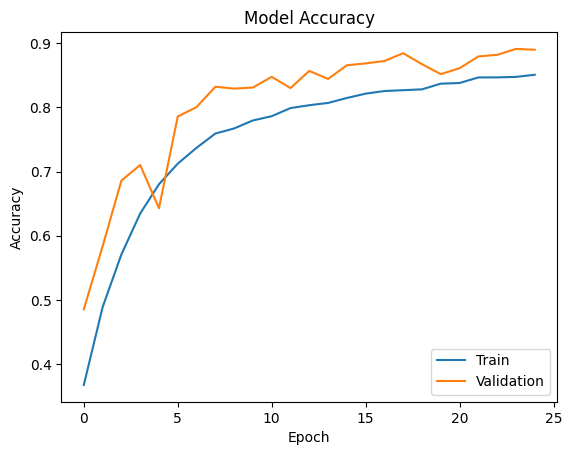

In [19]:
# Plots the training and validation accuracy over the number of epochs.
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.show()

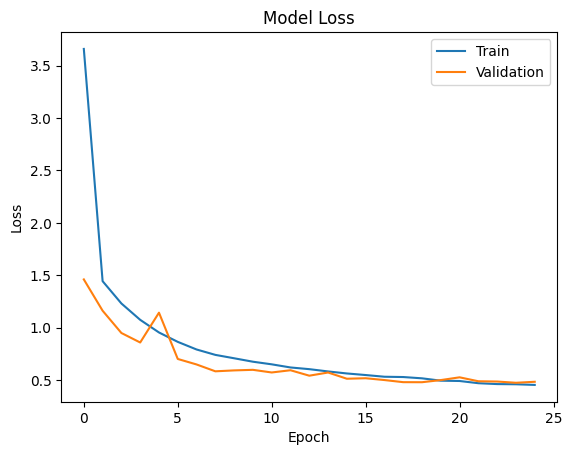

In [20]:
# Plots the training and validation loss over the number of epochs.
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

Our results from this basic model are quite good!
The model has a validation accuracy of around 89%, but begins to slightly overfit the data at around 4 epoch mark and 20 epoch mark.

This could be due to an anomalous local minima that the model gets trapped in, and can be improved with some regularisation and tuning of model hyperparameters.

# Model  Dense Layers

All Conv2D layers have been replaced with Dense layers instead. The input shape has been flattened before it is passed into the Dense layers.

In [155]:
from keras import layers
from keras import models

model_2 = keras.Sequential()
model_2.add(layers.Flatten(input_shape=(28, 28, 1)))
model_2.add(keras.layers.Dense(24, activation='relu'))
model_2.add(keras.layers.Dense(16, activation='relu'))
model_2.add(keras.layers.Dense(16, activation='relu'))
model_2.add(keras.layers.Dense(16, activation='relu'))

model_2.add(keras.layers.Dense(11, activation='softmax'))

model_2.summary()

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_39 (Flatten)        (None, 784)               0         
                                                                 
 dense_120 (Dense)           (None, 24)                18840     
                                                                 
 dense_121 (Dense)           (None, 16)                400       
                                                                 
 dense_122 (Dense)           (None, 16)                272       
                                                                 
 dense_123 (Dense)           (None, 16)                272       
                                                                 
 dense_124 (Dense)           (None, 11)                187       
                                                                 
Total params: 19971 (78.01 KB)
Trainable params: 1997

In [156]:
model_2.compile(optimizer=keras.optimizers.SGD(learning_rate=0.001),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [157]:
# We use the data generator to pass the training and validation data to the model to train it.
history_2 = model_2.fit(train_x, keras.utils.to_categorical(train_y), batch_size = 64,
                    validation_data=(val_x, keras.utils.to_categorical(val_y)),
                    epochs= 25)

Epoch 1/25
203/203 [==============================] - 1s 4ms/step - loss: 9.4595 - accuracy: 0.2603 - val_loss: 2.0468 - val_accuracy: 0.3069
Epoch 2/25
203/203 [==============================] - 1s 3ms/step - loss: 2.2047 - accuracy: 0.2992 - val_loss: 1.9564 - val_accuracy: 0.3161
Epoch 3/25
203/203 [==============================] - 1s 3ms/step - loss: 2.1674 - accuracy: 0.3032 - val_loss: 1.9435 - val_accuracy: 0.3190
Epoch 4/25
203/203 [==============================] - 1s 3ms/step - loss: 2.1486 - accuracy: 0.3040 - val_loss: 1.9321 - val_accuracy: 0.3169
Epoch 5/25
203/203 [==============================] - 1s 3ms/step - loss: 2.1350 - accuracy: 0.3050 - val_loss: 1.9220 - val_accuracy: 0.3165
Epoch 6/25
203/203 [==============================] - 1s 3ms/step - loss: 2.1240 - accuracy: 0.3037 - val_loss: 1.9064 - val_accuracy: 0.3357
Epoch 7/25
203/203 [==============================] - 1s 3ms/step - loss: 2.1103 - accuracy: 0.3077 - val_loss: 1.8812 - val_accuracy: 0.3712
Epoch 

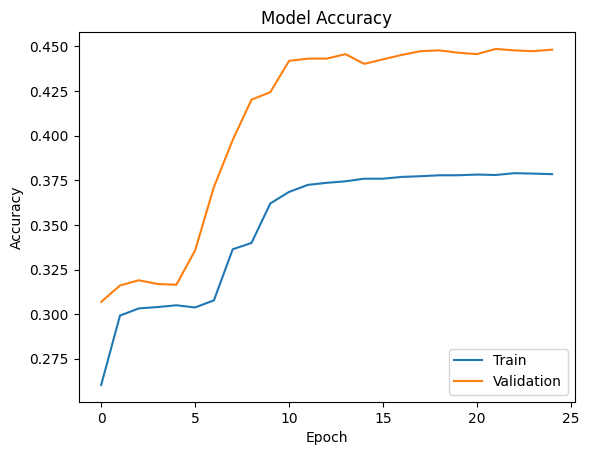

In [158]:
# Plots the training and validation accuracy over the number of epochs.
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.show()

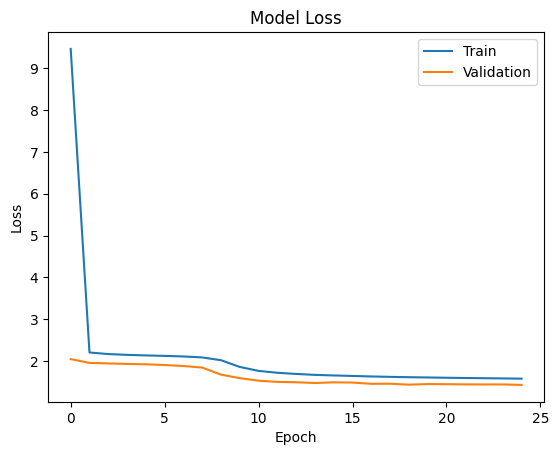

In [159]:
# Plots the training and validation loss over the number of epochs.
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

Results safely indicate that the model has actually underfit on the training data. There is a significant gap between the training and the validation accuracy, but both are very low.

This is reinforced by the model loss curves, which start very high and then slowly stagnate and plateau, albeit remaining high.

# Model - Deep Network Design

## Data Augmentation
Here, we define a new data augmentation fucntion to be used in our deep network design.
We rescale the image pixels from the range [0,255] into the range [0,1] to be better used by the network.

We augment the training data to give the model more images to process, so that we can raise the model's accuracy and prevent overfitting due to too little samples.

The validation data has not been augmented!

In [75]:
train_datagen = ImageDataGenerator(rotation_range =40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.1,
                                   shear_range=0.2,
                                   zoom_range=0.1,
                                   fill_mode='nearest',
                                   rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(train_x, to_categorical(train_y), batch_size=64)

validation_generator = test_datagen.flow(val_x, to_categorical(val_y), batch_size=64)

We define the model structure below.
MaxPooling and Dropout layers were added to tackle model overfitting, as well as regularisers at the dense layers.

Dropout weights were kept quite low, since we don't have that much input data samples to begin with.

In [135]:
from keras import layers
from keras import models
from keras import regularizers

model_3 = keras.Sequential()
model_3.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape= (28, 28, 1)))
model_3.add(keras.layers.MaxPooling2D((2, 2)))

model_3.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
model_3.add(keras.layers.MaxPooling2D((2, 2)))

model_3.add(keras.layers.Conv2D(128, (3, 3), activation='relu'))
model_3.add(keras.layers.MaxPooling2D((2, 2)))

model_3.add(keras.layers.Flatten())
model_3.add(keras.layers.Dropout(0.5))
model_3.add(keras.layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
model_3.add(keras.layers.Dense(32, activation='relu'))
model_3.add(keras.layers.Dense(11, activation='softmax'))

model_3.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_82 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_74 (MaxPooli  (None, 13, 13, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_83 (Conv2D)          (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_75 (MaxPooli  (None, 5, 5, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_84 (Conv2D)          (None, 3, 3, 128)         73856     
                                                                 
 max_pooling2d_76 (MaxPooli  (None, 1, 1, 128)       

In [137]:
from keras import optimizers
model_3.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['acc'])

In [138]:
# We use the data generator to pass the training and validation data to the model to train it.
history_deep = model_3.fit(train_generator, validation_data=(validation_generator), epochs=25)

Epoch 1/25
203/203 [==============================] - 41s 187ms/step - loss: 1.9713 - acc: 0.3071 - val_loss: 1.5653 - val_acc: 0.4156
Epoch 2/25
203/203 [==============================] - 18s 89ms/step - loss: 1.6019 - acc: 0.4224 - val_loss: 1.2005 - val_acc: 0.5723
Epoch 3/25
203/203 [==============================] - 17s 86ms/step - loss: 1.3996 - acc: 0.5067 - val_loss: 1.1345 - val_acc: 0.6229
Epoch 4/25
203/203 [==============================] - 18s 89ms/step - loss: 1.2760 - acc: 0.5517 - val_loss: 1.3732 - val_acc: 0.5849
Epoch 5/25
203/203 [==============================] - 17s 85ms/step - loss: 1.1892 - acc: 0.5840 - val_loss: 0.9918 - val_acc: 0.6839
Epoch 6/25
203/203 [==============================] - 17s 84ms/step - loss: 1.1127 - acc: 0.6106 - val_loss: 0.9712 - val_acc: 0.6952
Epoch 7/25
203/203 [==============================] - 18s 90ms/step - loss: 1.0558 - acc: 0.6264 - val_loss: 0.7952 - val_acc: 0.7241
Epoch 8/25
203/203 [==============================] - 18s 88m

In [139]:
history_dict = history_deep.history
history_dict.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

Here, we'll evaluate the model on the test data

## Plot Learning Curves
This is where we visualise the training of the model.

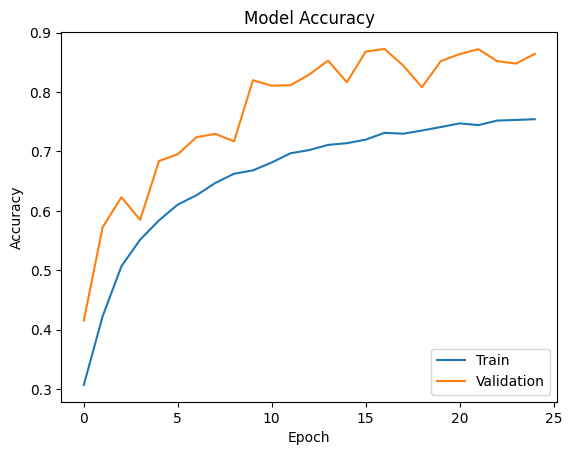

In [140]:
# Plots the training and validation accuracy over the number of epochs.
plt.plot(history_deep.history['acc'])
plt.plot(history_deep.history['val_acc'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.show()

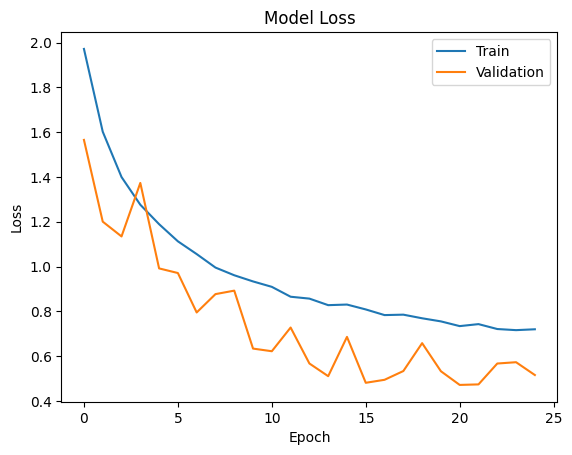

In [141]:
# Plots the training and validation loss over the number of epochs.
plt.plot(history_deep.history['loss'])
plt.plot(history_deep.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

Here, we'll evaluate the model on the test data.
Our current model, trained over 50 epochs, ended up with an accuracy around 85%

Looking at our curves, while the accuracy is increasing and the loss is decreasing as we traverse through epochs, the lines don't seem to be converging.

This could simply be due to the fact that the model hasn't been trained for long enough (25 epochs is relatively short, but I was limited on GPU availability in Colab).

The validation data is relatively spiky, which, as mentioned in my other notebook, is just due to the optimiser used and could be improved by manipulating the batch size, but that now has implications for the number of steps per epoch. We can also get trapped in a local minima, leading to our model getting stuck.


## Learnings
What was interesting to note was that the basic convnet model provided in the example notebook, actually had a higher accuracy, but more importantly, converged! This was achieved without using any data augmentation as well, which means that the model performs very well on the training data we've provided.

In the case where there isn't any convolutional layers, the model trains extremely quickly, but the accuracy is poor by comparision (around 40%). More dense layers may improve the training and validation accuracy, but even with those results we can safely assume that the model has overfit itself on the training data.

Further improvements could be made by experimenting on the hyperparameters, such as the regularization weights, learning rates and batch steps per epoch. With the proper hardware, I'd recommend evaluating by incoporating a pre-trained model and model architecture, like ResNet-18 for example.

# Time Spent on Assignment

In total, I spend around 40-50 hours on this assignment.
A lot of that time was just waiting around for the model to run in Colab as Colab limits your GPU access, so models had no choice to be tested using CPUs which increased training time unbearably.
Some model iterations took over 25 mins to run.